In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import f_oneway, ttest_ind
from Architectures.AE import AE1
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from glob import glob
from tqdm import tqdm

In [3]:
all_latent = []
for fp in tqdm(glob("Data/Latent projections/*.npy"), "Loading latent spaces"):
    # print(fp)
    with open(fp,"br") as f:
        all_latent.append(np.load(f))
print(all_latent[0].shape)

Loading latent spaces: 100%|██████████| 16/16 [00:00<00:00, 65.55it/s]

(2000, 10)


The latent spaces above come from the compare_models.ipynb notebook.

Refer to that notebook if you haven't calculated the latent spaces yet.

In [4]:
# Scale the spaces
all_latent_scaled = [StandardScaler().fit_transform(latent) for latent in all_latent]

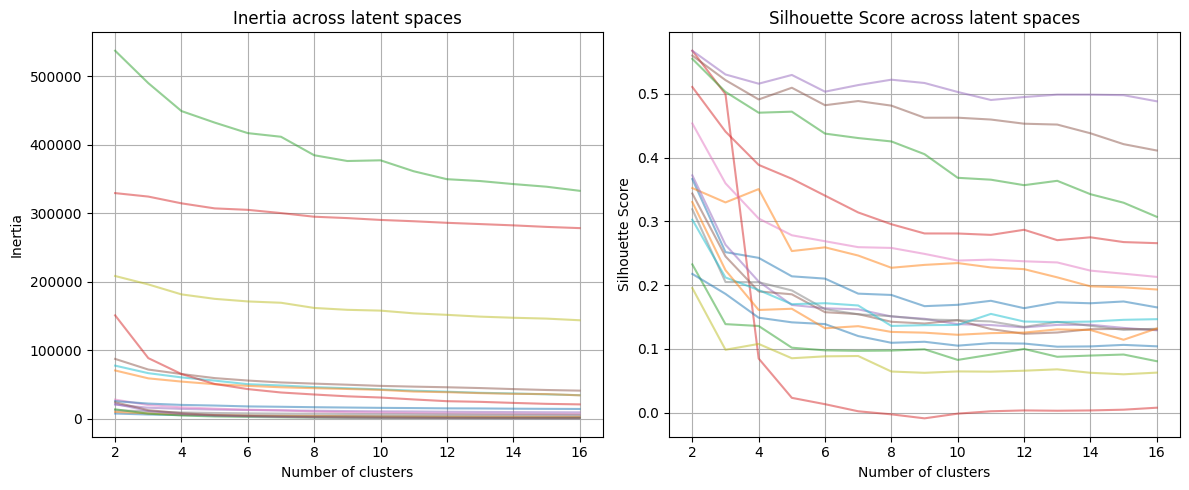

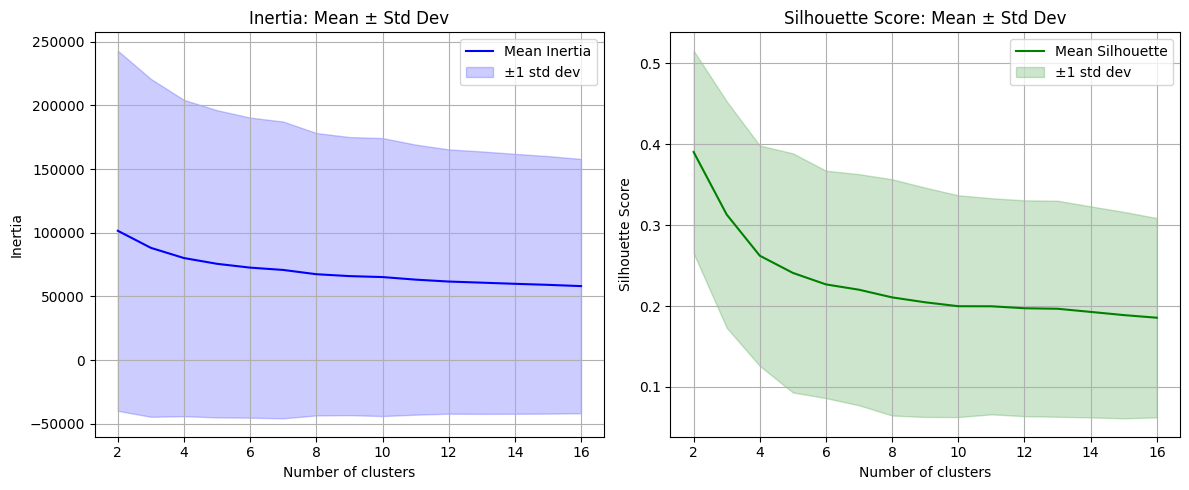

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of clusters to evaluate
cluster_range = range(2, 17)
n_clusters_list = list(cluster_range)

# To store results
all_inertias = []
all_silhouettes = []

# Loop over all latent spaces
for latent_space in all_latent_scaled:
    inertias = []
    silhouettes = []

    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(latent_space)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(latent_space, labels))

    all_inertias.append(inertias)
    all_silhouettes.append(silhouettes)

# Convert to NumPy arrays for easier manipulation
inertias_array = np.array(all_inertias)
silhouettes_array = np.array(all_silhouettes)

# -------- Plot 1: All curves --------
plt.figure(figsize=(12, 5))

# Inertia plot
plt.subplot(1, 2, 1)
for i in range(len(all_latent_scaled)):
    plt.plot(n_clusters_list, inertias_array[i], alpha=0.5, label=f'Latent {i+1}')
plt.title("Inertia across latent spaces")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)

# Silhouette score plot
plt.subplot(1, 2, 2)
for i in range(len(all_latent_scaled)):
    plt.plot(n_clusters_list, silhouettes_array[i], alpha=0.5, label=f'Latent {i+1}')
plt.title("Silhouette Score across latent spaces")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

# -------- Plot 2: Mean ± Std Dev (Uncertainty interval) --------
mean_inertia = np.mean(inertias_array, axis=0)
std_inertia = np.std(inertias_array, axis=0)

mean_silhouette = np.mean(silhouettes_array, axis=0)
std_silhouette = np.std(silhouettes_array, axis=0)

plt.figure(figsize=(12, 5))

# Inertia with uncertainty
plt.subplot(1, 2, 1)
plt.plot(n_clusters_list, mean_inertia, 'b-', label='Mean Inertia')
plt.fill_between(n_clusters_list, mean_inertia - std_inertia, mean_inertia + std_inertia, color='b', alpha=0.2, label='±1 std dev')
plt.title("Inertia: Mean ± Std Dev")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.legend()
plt.grid(True)

# Silhouette with uncertainty
plt.subplot(1, 2, 2)
plt.plot(n_clusters_list, mean_silhouette, 'g-', label='Mean Silhouette')
plt.fill_between(n_clusters_list, mean_silhouette - std_silhouette, mean_silhouette + std_silhouette, color='g', alpha=0.2, label='±1 std dev')
plt.title("Silhouette Score: Mean ± Std Dev")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
all_subjects

,imageid,subject,imgDate,Group,num_events,AERELAD,AERELCM,AERELFLRBTBN,AERELFLRBPR,AEHIMG,...,COMPLXCHKTIME,MMSE_INTERP,MMSE_MEAN,first_mmse_year,concave,convex,is_AD,is_MCI,APOE-4,cluster_id
0,0,S6546,2022-10-03,0,4,0.0,0.25,0.0,0.0,0.0,...,147.000000,28.000000,27.666667,2005,1631980.0,1.770903e+06,False,False,1,7
1,1,S6570,2018-08-31,0,3,0.0,0.00,0.0,0.0,0.0,...,124.000000,29.990591,29.000000,2005,1628163.0,1.767325e+06,False,False,0,14
2,2,S6570,2022-09-20,0,3,0.0,0.00,0.0,0.0,0.0,...,124.000000,28.000000,29.000000,2005,1580466.0,1.704634e+06,False,False,0,14
3,3,S6574,2018-09-07,0,5,0.0,0.00,0.0,0.0,0.0,...,170.666667,28.027778,29.000000,2005,1477454.0,1.629739e+06,False,False,0,3
4,4,S6574,2020-11-02,0,5,0.0,0.00,0.0,0.0,0.0,...,170.666667,30.000000,29.000000,2005,1595403.0,1.739119e+06,False,False,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,S0300,2008-10-13 16:43:20,2,12,0.0,0.00,0.0,0.0,0.0,...,NaN,26.000000,25.000000,2011,1654017.0,1.797397e+06,True,False,2,6
1996,1996,S0916,2006-12-03 14:39:25,2,18,0.0,0.00,0.0,0.0,0.0,...,NaN,21.000000,18.000000,2011,1597718.0,1.738169e+06,True,False,2,5
1997,1997,S1262,2007-08-05 14:09:40,2,14,0.0,0.00,0.0,0.0,0.0,...,NaN,15.784265,12.600000,2010,1601268.0,1.727674e+06,True,False,0,13
1998,1998,S0404,2006-12-22 19:35:16,2,11,0.0,0.00,0.0,0.0,0.0,...,NaN,19.624700,20.250000,2011,1609039.0,1.749592e+06,True,False,0,5


: 

C:\Users\PieHu\AppData\Local\Temp\ipykernel_11120\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


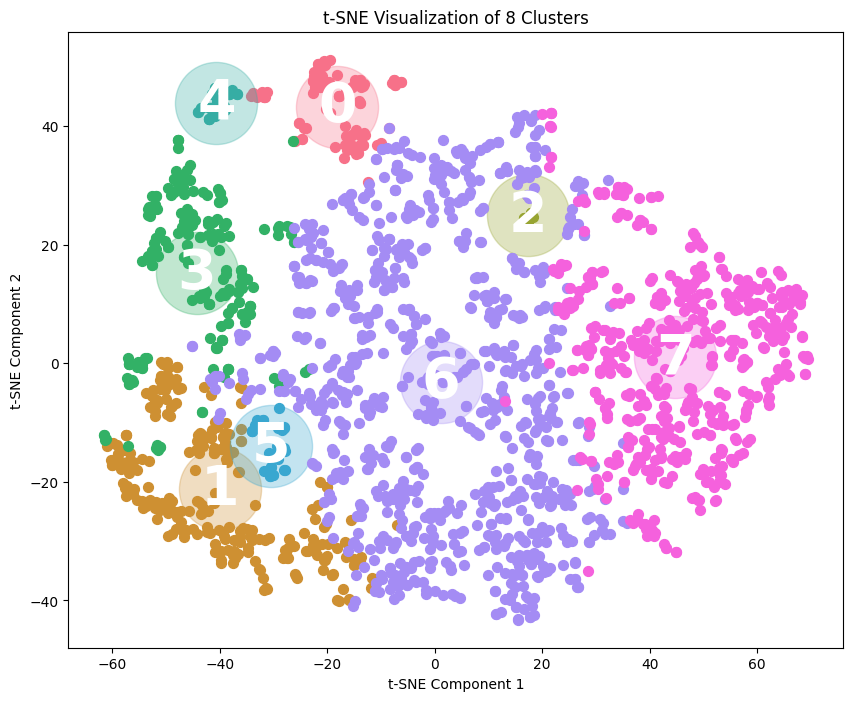

C:\Users\PieHu\AppData\Local\Temp\ipykernel_11120\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


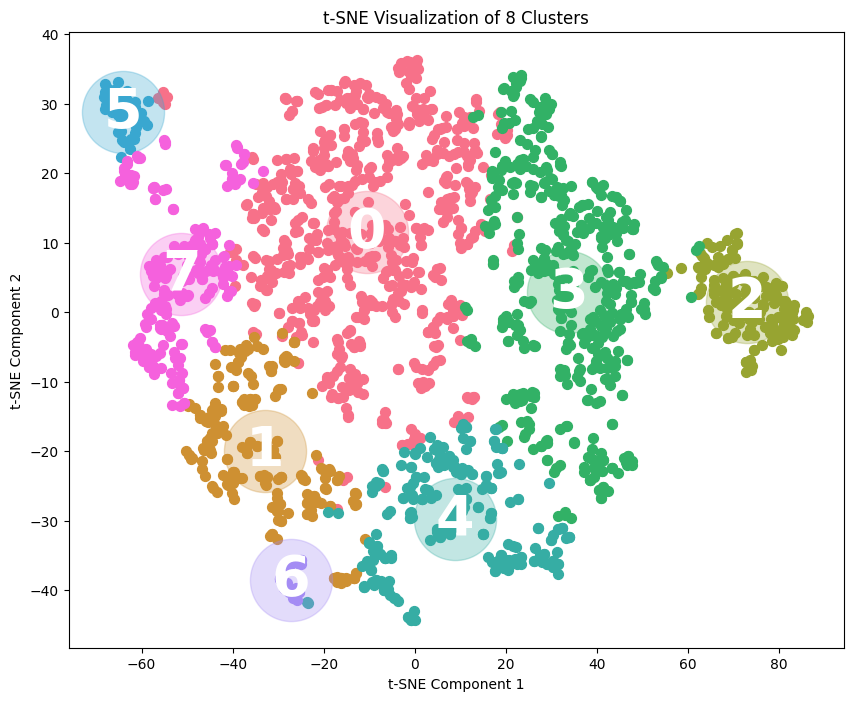

In [ ]:
def find_clusters(data, n_clusters=3):
    """
    Perform clustering on MRI latent space data and calculate p-values.
    
    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    n_clusters (int): Number of clusters to form.
    
    Returns:
    tuple: Cluster labels for each sample, p-values for samples, p-values for clusters.
    """
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    
    # Calculate p-values for each feature using ANOVA
    p_values_samples = []
    for i in range(data.shape[1]):
        feature_data = [data[labels == cluster, i] for cluster in range(n_clusters)]
        f_stat, p_value = f_oneway(*feature_data)
        p_values_samples.append(p_value)
    
    # # Calculate p-values for clusters using t-test (pairwise comparisons)
    # p_values_clusters = np.ones((n_clusters, n_clusters))
    # for i in range(n_clusters):
    #     for j in range(i+1, n_clusters):
    #         t_stat, p_value = ttest_ind(data[labels == i], data[labels == j], equal_var=False)
    #         print(p_value)
    #         p_values_clusters[i, j] = p_value
    #         p_values_clusters[j, i] = p_value
    
    return labels, np.array(p_values_samples)#, p_values_clusters

def find_clusters(data, n_clusters=3): # Spectral
    """
    Perform clustering on MRI latent space data using Spectral Clustering and calculate p-values.
    
    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    n_clusters (int): Number of clusters to form.
    
    Returns:
    tuple: Cluster labels for each sample, p-values for samples.
    """
    
    # Perform Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(data)
    
    # Calculate p-values for each feature using ANOVA
    p_values_samples = []
    for i in range(data.shape[1]):
        feature_data = [data[labels == cluster, i] for cluster in range(n_clusters)]
        f_stat, p_value = f_oneway(*feature_data)
        p_values_samples.append(p_value)
    
    return labels, np.array(p_values_samples)



def plot_clusters(data, labels, n_clusters=3, title='t-SNE Visualization of Clusters'):
    """
    Plot the clusters using t-SNE for 2D visualization.

    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    labels (numpy.ndarray): Cluster labels for each sample.
    n_clusters (int): Number of clusters.
    """
    tsne = TSNE(n_components=2, random_state=42)
    data_2d = tsne.fit_transform(data)

    # Calculate cluster means
    cluster_means = np.array([data_2d[labels == i].mean(axis=0) for i in range(n_clusters)])

    # Plot using seaborn for better aesthetics
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette('husl', n_clusters)
    
    for i in range(n_clusters):
        # Plot cluster mean with a semi-transparent bubble
        plt.scatter(cluster_means[i, 0], cluster_means[i, 1], color=palette[i], s=3500, alpha=0.3)
        
        # Display cluster ID in white
        plt.text(cluster_means[i, 0], cluster_means[i, 1], str(i), color='white',
                 fontsize=40, ha='center', va='center', fontweight='bold')
        
        plt.scatter(data_2d[labels == i, 0], data_2d[labels == i, 1], label=f'Cluster {i}', color=palette[i], s=50)

    # plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

for latent_scaled in all_latent_scaled[:2]:
    for n_clusters in [8]: # 4, 8, 12
        labels, p_values_samples = find_clusters(latent_scaled, n_clusters=n_clusters)
        plot_clusters(latent_scaled, labels, n_clusters=n_clusters,title=f't-SNE Visualization of {n_clusters} Clusters')


C:\Users\PieHu\AppData\Local\Temp\ipykernel_12356\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


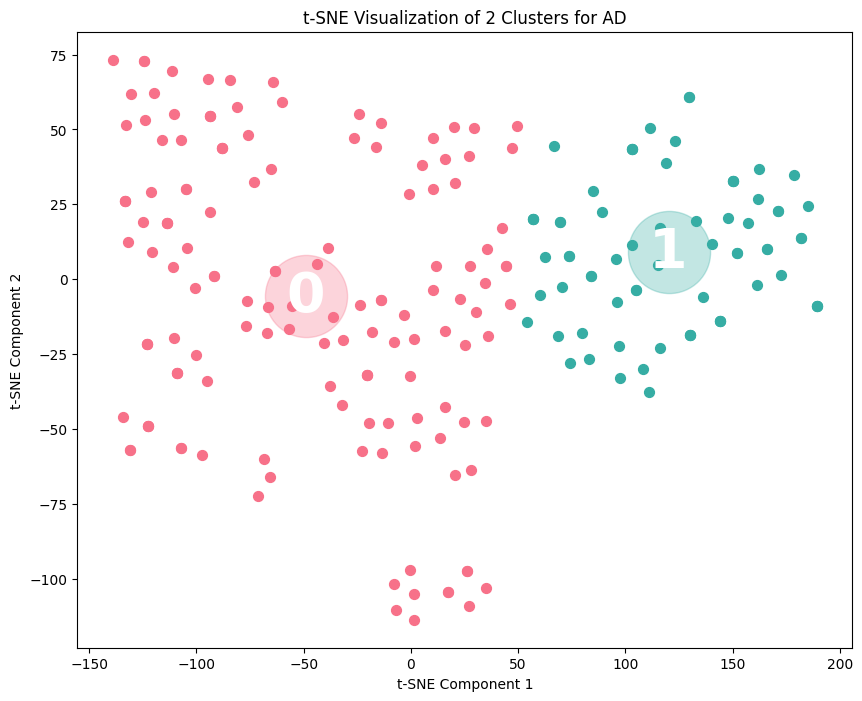

C:\Users\PieHu\AppData\Local\Temp\ipykernel_12356\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


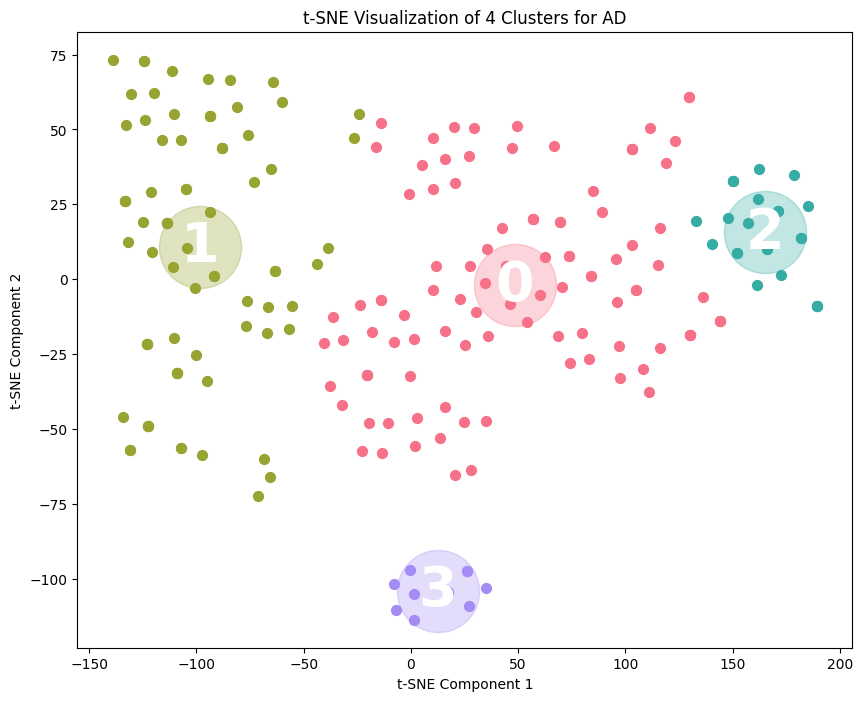

C:\Users\PieHu\AppData\Local\Temp\ipykernel_12356\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


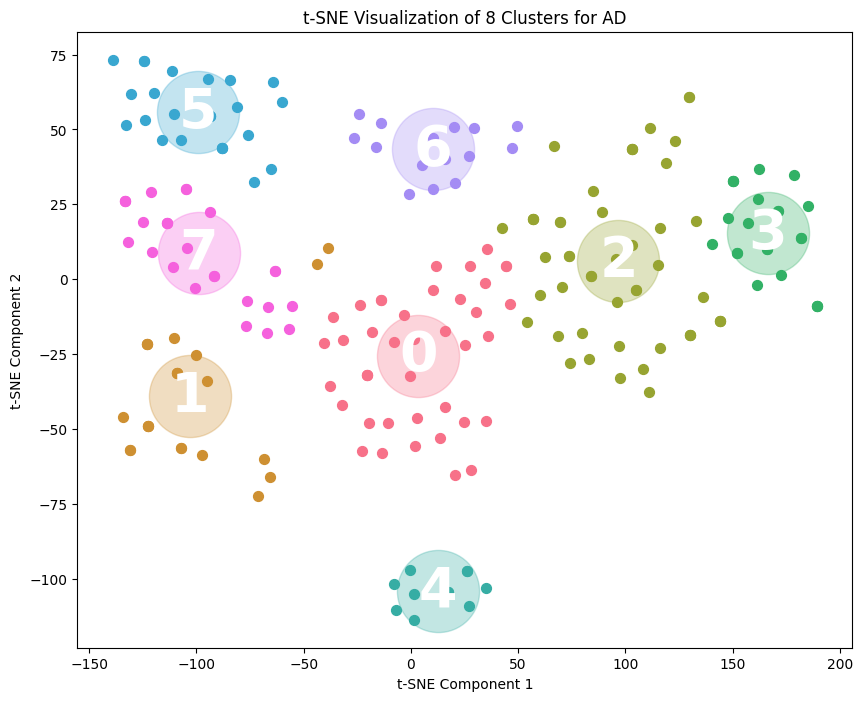

In [5]:
group = "AD"
group_latent = latent_scaled[1787 : 2000]
for n_clusters in [2, 4, 8]:
    labels, p_values_samples = find_clusters(group_latent, n_clusters=n_clusters)
    plot_clusters(group_latent, labels, n_clusters=n_clusters,title=f't-SNE Visualization of {n_clusters} Clusters for {group}')

C:\Users\PieHu\AppData\Local\Temp\ipykernel_12356\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


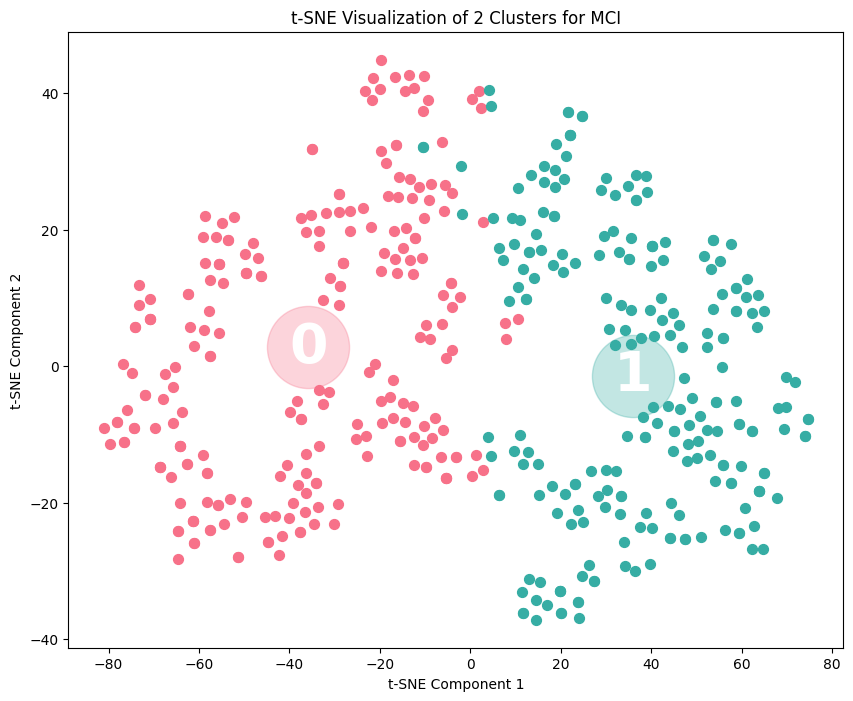

C:\Users\PieHu\AppData\Local\Temp\ipykernel_12356\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


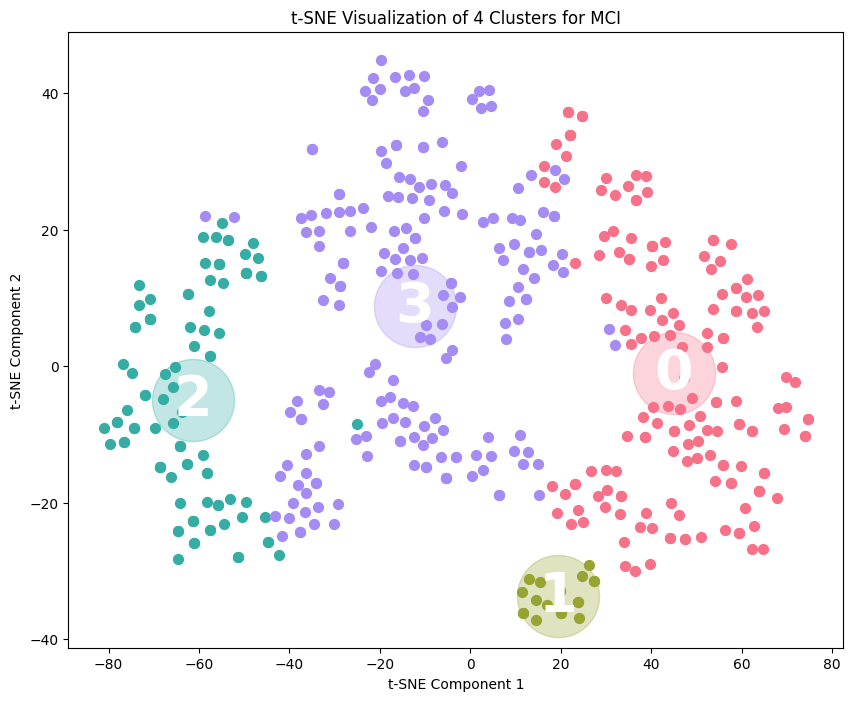

C:\Users\PieHu\AppData\Local\Temp\ipykernel_12356\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


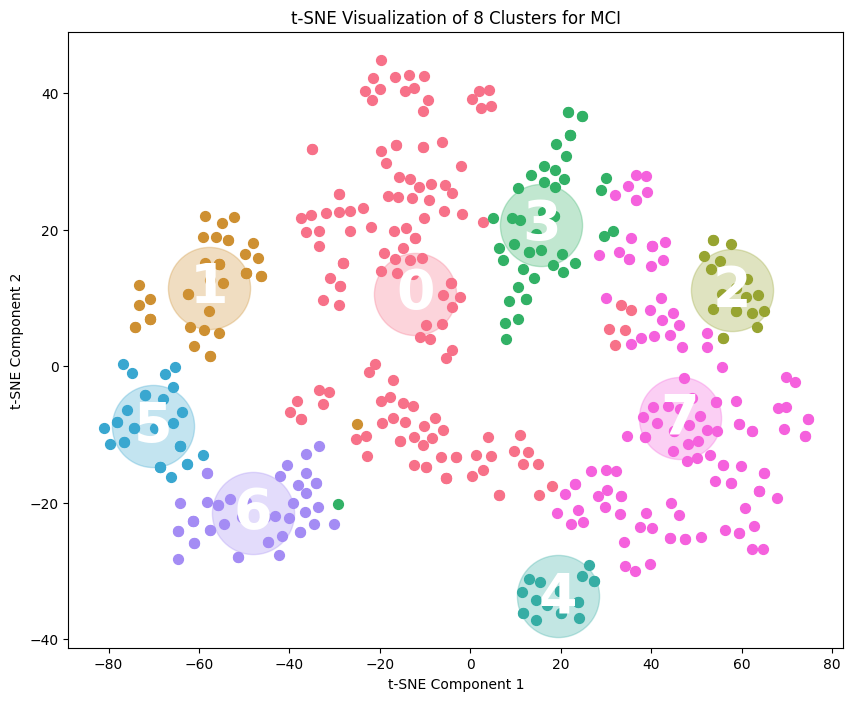

In [6]:
group = "MCI"
group_latent = latent_scaled[1326 : 1787]
for n_clusters in [2, 4, 8]:
    labels, p_values_samples = find_clusters(group_latent, n_clusters=n_clusters)
    plot_clusters(group_latent, labels, n_clusters=n_clusters,title=f't-SNE Visualization of {n_clusters} Clusters for {group}')

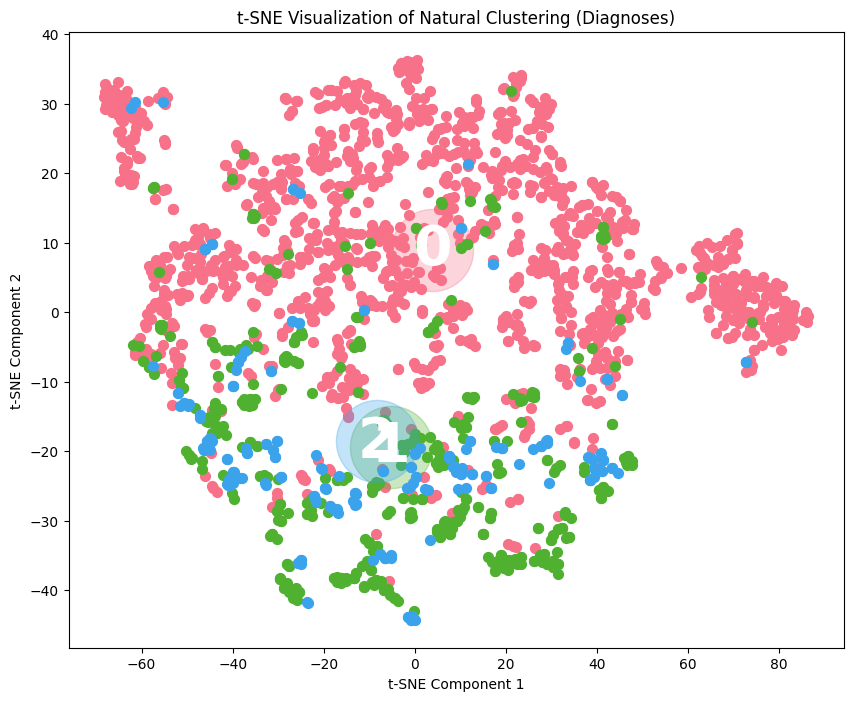

In [7]:
labels_nat = np.zeros(len(latent_scaled))
labels_nat[1326 : 1787]=1
labels_nat[1787 : 2000]=2
# [all_subjects["Group"]!=0]
plot_clusters(latent_scaled, labels_nat, n_clusters=3,title='t-SNE Visualization of Natural Clustering (Diagnoses)')

In [ ]:
import pandas as pd
all_subjects = pd.read_csv("Data/subjects_nan.csv").drop(columns="Unnamed: 0")
all_subjects["is_AD"] = all_subjects["Group"] == 2
all_subjects["is_MCI"] = all_subjects["Group"] == 1
all_subjects["APOE-4"] = (all_subjects["APOEGEN_1"] == 4).astype("int") + (all_subjects["APOEGEN_2"] == 4).astype("int")

all_subjects["age"] = all_subjects["first_mmse_year"] - all_subjects["PTDOBYY"]
# age_AD = all_subjects.loc[all_subjects["Group"]==2,"age"].mean()
# age_CN = all_subjects.loc[all_subjects["Group"]==0,"age"].mean()
# print(f"{age_AD:.2f} - {age_CN:.2f} = {age_AD - age_CN:.2f}")

first_visit = all_subjects.sort_values("imgDate").groupby("subject").first()

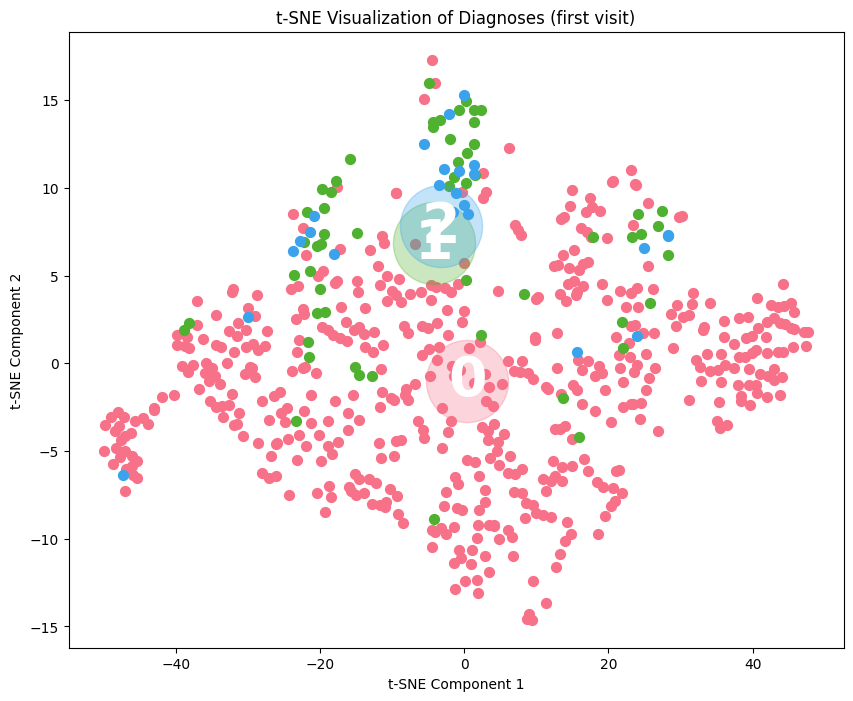

In [26]:
labels_nat = np.zeros(len(latent_scaled))
labels_nat[1326 : 1787]=1
labels_nat[1787 : 2000]=2
plot_clusters(latent_scaled[first_visit["imageid"]], labels_nat[first_visit["imageid"]], n_clusters=3,title='t-SNE Visualization of Diagnoses (first visit)')

Trying to explain the clustering behaviour we see using the clinical data about the subjects

C:\Users\PieHu\AppData\Local\Temp\ipykernel_11120\1179885683.py:59: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


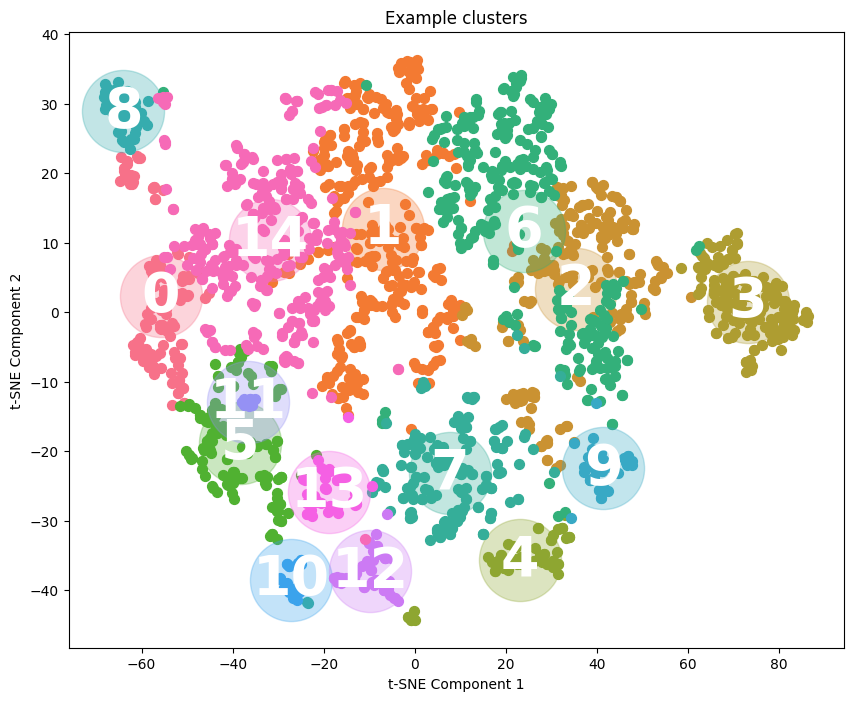

In [27]:
# latent_scaled = all_latent_scaled[0]
n_clusters = 15 # [first_visit["imageid"]]
labels, p_values_samples = find_clusters(latent_scaled, n_clusters=n_clusters)
plot_clusters(latent_scaled, labels, n_clusters=n_clusters,title='Example clusters')

X = all_subjects.drop(columns=["imageid","subject","Group", "is_AD","is_MCI"]).copy()
y = labels
all_subjects["cluster_id"] = labels

In [ ]:
import pandas as pd
import scipy.stats as stats

# Assuming df_merged is the merged dataframe with ['subject', 'cluster_id', 'feature_1', ...]

clusters = all_subjects['cluster_id'].unique()
features = X.drop(columns="imgDate").columns

anova_results = []

for feature in features:
    # Extract feature values for all clusters
    if feature not in all_subjects: continue
    cluster_data = [all_subjects[all_subjects['cluster_id'] == c][feature] for c in clusters]
    
    # Perform one-way ANOVA
    f_stat, p_anova = stats.f_oneway(*cluster_data)
    
    anova_results.append({'feature': feature, 'p_anova': p_anova})

# Convert to DataFrame
df_anova_results = pd.DataFrame(anova_results)
important_features = df_anova_results[~pd.isna(df_anova_results["p_anova"])] # Since some features contain zero variance, we get NaN values
important_features[important_features["p_anova"]<0.01].sort_values(by="p_anova").reset_index(drop=True)

C:\Users\PieHu\AppData\Local\Temp\ipykernel_11120\1557429407.py:17: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_anova = stats.f_oneway(*cluster_data)


,feature,p_anova
0,PXCHEST,0.016181
1,AERELPAN,0.036446
2,AEHIMG,0.059664
3,AERELAD,0.108430
4,concave,0.127215
5,first_mmse_year,0.179877
6,convex,0.181279
7,AERELFLRBTBN,0.199111
8,AERELFLRBPR,0.295786
9,PXGENAPP,0.495781


Significant features to predict cluster: ``num_events``, ``AEHLUMB``, ``AERELPAN``, ``AEHCMEDS``, ``AESERIOUS``.

Features are gathered from , meaning that the mean of these features represent the expected number of events a subject experiences.

- ``num_events``: How many adverse events has subject X experienced?
- ``AEHLUMB``: Serious event related to lumbar puncture.
- ``AERELPAN``: Serious event related to COVID-19.
- ``AEHCMEDS``: Was medication needed?
- ``AESERIOUS``: Was event serious at any time during the trial?

In [11]:
print("Mean values for various clusters.")
all_subjects[["is_AD","is_MCI","cluster_id","PTCOGBEG","PTDOBYY","num_events","Namenda","PTGENDER","concave","APOE-4"]].groupby(by="cluster_id").mean()

Mean values for various clusters.


,is_AD,is_MCI,PTCOGBEG,PTDOBYY,num_events,Namenda,PTGENDER,concave,APOE-4
cluster_id,,,,,,,,,
0,0.041667,0.200000,9265.051020,1941.900000,5.833333,0.080392,1.416667,1.605979e+06,0.400000
1,0.006079,0.082067,9384.221154,1943.765957,4.443769,0.014667,1.547112,1.598169e+06,0.437690
2,0.039024,0.126829,9288.488889,1945.170732,5.253659,0.017081,1.629268,1.605067e+06,0.453659
3,0.019608,0.013072,9944.700680,1947.372549,3.555556,0.000000,1.771242,1.600889e+06,0.457516
4,0.090909,0.848485,5555.555556,1931.606061,13.833333,0.198961,1.151515,1.611629e+06,0.924242
5,0.426471,0.419118,4388.596491,1928.301471,10.389706,0.337382,1.198529,1.605232e+06,1.014706
6,0.047458,0.077966,9608.360902,1944.627119,3.983051,0.006207,1.691525,1.605729e+06,0.369492
7,0.263158,0.567251,5345.880597,1934.520468,9.678363,0.365672,1.502924,1.610034e+06,0.637427
8,0.040000,0.000000,9999.000000,1945.100000,2.600000,0.001894,1.700000,1.614330e+06,0.480000


In [12]:
all_subjects.groupby(["PTGENDER","APOE-4"])[["is_AD","is_MCI"]].mean()

is_AD    is_MCI
PTGENDER APOE-4                    
1.0      0       0.003810  0.278095
         1       0.125392  0.385580
         2       0.393939  0.474747
2.0      0       0.100932  0.135093
         1       0.086420  0.098765
         2       0.438202  0.292135

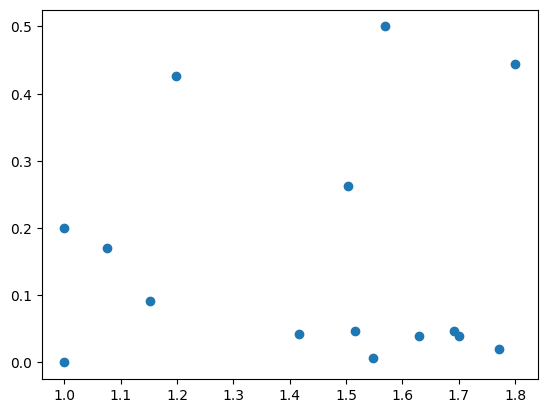

In [13]:
n=all_subjects[["is_AD","is_MCI","cluster_id","PTCOGBEG","PTDOBYY","num_events","Namenda","PTGENDER","APOE-4"]].groupby(by="cluster_id").mean()
plt.scatter(n["PTGENDER"],n["is_AD"])

AEHLUMB may be lower in the AD clusters because positive diagnosis stops further testing. Thus we get the case where the younger you get diagnosed with AD, the fewer tests you do in total.

MOTHAGE is lower in AD clusters because testing is biased; people suffering from AD may not remember their mothers age. Indeed we see this for a number of variables. The AD group has more missing values than the non-AD group:

In [15]:
valid_cols = []
for c in all_subjects:
    try:
        var = all_subjects.loc[all_subjects["Group"]!=0,c].var()
        if var == 0:
            print(c)
        else:
            valid_cols.append(c)
    except: pass
len(valid_cols)

AERELAD
AERELCM
AERELFLRBTBN
AERELFLRBPR
AEHIMG
AERELTAU
AERELNAV
AERELMK
AERELPI
AEHLUMB
AERELCOVID
AERELPAN
AERELATESP
Cognex
PXGENAPP
PXABDOM
PXOTHER
PXABNORM
PTSOURCE


102

In [ ]:
# valid_cols.append("Cognex")
# all_subjects = all_subjects[valid_cols]

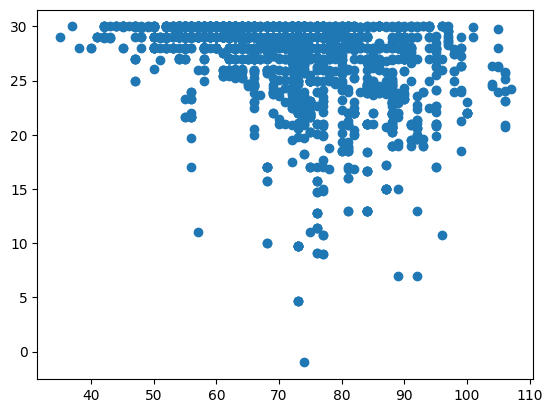

In [30]:
plt.scatter(all_subjects["first_mmse_year"]-all_subjects["PTDOBYY"], all_subjects["MMSE_INTERP"])

In [31]:
all_subjects[["is_AD","PTGENDER","is_MCI","PTHOME"]].groupby(by=["PTGENDER","is_AD"]).mean()

is_MCI    PTHOME
PTGENDER is_AD                    
1.0      False  0.366589  1.379350
         True   0.000000  2.086420
2.0      False  0.156757  1.427027
         True   0.000000  1.689394

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming 'all_subjects' is your DataFrame

# Prepare the dataset
X = all_subjects[["age","PTGENDER", "PTHOME", "PTMARRY", "PTHAND", "PXPERIPH", "PXMUSCUL", "SIBDEMENT", "Anti-depressant", "PXEXTREM","PXSKIN"]]  # Features: all columns except 'is_AD'
mask = ~pd.isna(all_subjects["PXPERIPH"])
X= X[mask].fillna(0)
# X = X.dropna()#X.fillna(0)
y = all_subjects[['is_AD']]  # Target: 'is_AD'
y=y[mask].fillna(0)
X_scaled=StandardScaler().fit_transform(X)
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Optional: To see the coefficients of each feature in the model
coefficients = pd.DataFrame(model.coef_.T, X.columns, columns=['Coefficient'])
coefficients


Mean Squared Error: 0.08520198206754781
R-squared: 0.1466468149729171


,Coefficient
PTGENDER,0.039616
PTHOME,0.028789
PTMARRY,-0.023564
PTHAND,-0.026892
PXPERIPH,0.050814
PXMUSCUL,0.012932
SIBDEMENT,-0.023903
Anti-depressant,-0.026269
PXEXTREM,-0.011692
PXSKIN,0.025587


In [22]:
all_subjects.groupby(["Group","PTGENDER"]).size()

Group  PTGENDER
0      1.0         546
       2.0         780
1      1.0         316
       2.0         145
2      1.0          81
       2.0         132
dtype: int64

In [23]:
all_subjects.loc[all_subjects["Group"]==2,"PTHAND"].mean()

1.0093896713615023

We think there may be something wrong with the "Group" variable, since participants will have the same Group throughout the study, meaning this likely does not properly encode whether they have Alzheimers at that time. To check if there's something wrong here, we will predict the MMSE score for each participant at the time they took the image.

In [33]:
np.sum(all_subjects[["subject","MMSE_INTERP"]].groupby("subject").var()>0)

C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


MMSE_INTERP    297
dtype: int64

In [34]:
all_subjects["MMSE_INTERP"].quantile(0.6)

29.0

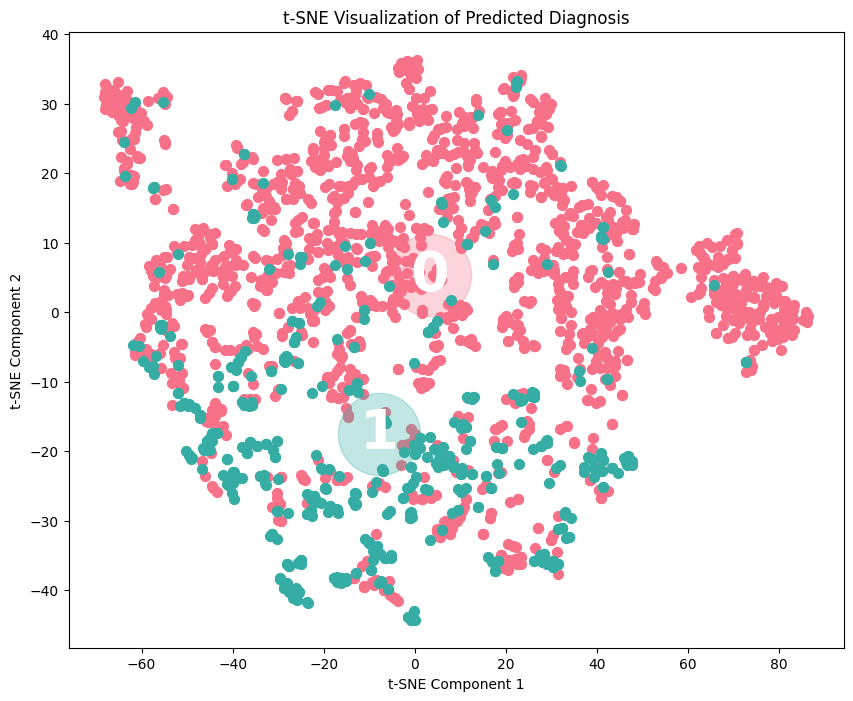

In [35]:
all_subjects["pred_is_AD"] = all_subjects["MMSE_INTERP"] < 26
# [all_subjects["Group"]!=0]
plot_clusters(latent_scaled, all_subjects["pred_is_AD"], n_clusters=2, title='t-SNE Visualization of Predicted Diagnosis')

In [39]:
all_subjects[["pred_is_AD","is_AD","is_MCI","cluster_id","PTCOGBEG","PTDOBYY","num_events","Namenda","PTGENDER"]].groupby("cluster_id").mean()

,pred_is_AD,is_AD,is_MCI,PTCOGBEG,PTDOBYY,num_events,Namenda,PTGENDER
cluster_id,,,,,,,,
0,0.216667,0.041667,0.200000,9265.051020,1941.900000,5.833333,0.080392,1.416667
1,0.088146,0.006079,0.082067,9384.221154,1943.765957,4.443769,0.014667,1.547112
2,0.141463,0.039024,0.126829,9288.488889,1945.170732,5.253659,0.017081,1.629268
3,0.026144,0.019608,0.013072,9944.700680,1947.372549,3.555556,0.000000,1.771242
4,0.606061,0.090909,0.848485,5555.555556,1931.606061,13.833333,0.198961,1.151515
5,0.661765,0.426471,0.419118,4388.596491,1928.301471,10.389706,0.337382,1.198529
6,0.098305,0.047458,0.077966,9608.360902,1944.627119,3.983051,0.006207,1.691525
7,0.543860,0.263158,0.567251,5345.880597,1934.520468,9.678363,0.365672,1.502924
8,0.060000,0.040000,0.000000,9999.000000,1945.100000,2.600000,0.001894,1.700000


Text(0, 0.5, 'AD rate')

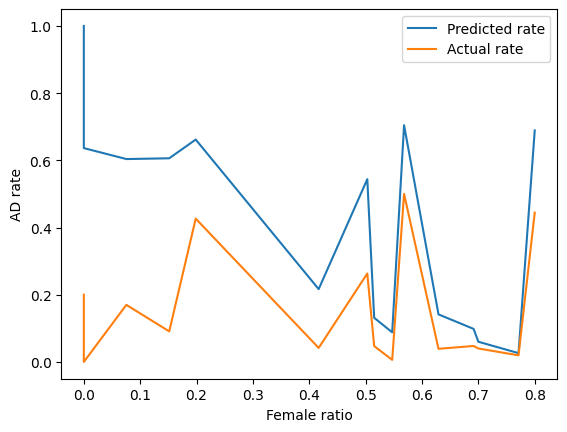

In [40]:
n=all_subjects[["pred_is_AD","is_AD","is_MCI","cluster_id","PTCOGBEG","PTDOBYY","num_events","Namenda","PTGENDER"]].groupby(by="cluster_id").mean()
n=n.sort_values(by="PTGENDER")
plt.plot(n["PTGENDER"]-1,n["pred_is_AD"],label="Predicted rate")
plt.plot(n["PTGENDER"]-1,n["is_AD"],label="Actual rate")
plt.legend()
plt.xlabel("Female ratio")
plt.ylabel("AD rate")

C:\Users\PieHu\AppData\Local\Temp\ipykernel_12356\1645053345.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = all_subjects.groupby("age_bin")["MMSE_INTERP"].mean()


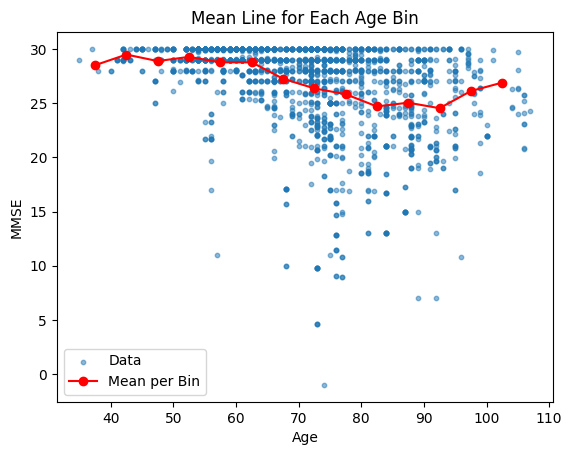

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bin edges (you can adjust the number of bins as needed)
bins = np.arange(all_subjects["age"].min(), all_subjects["age"].max(), 5)
all_subjects["age_bin"] = pd.cut(all_subjects["age"], bins)

# Compute the mean MMSE_INTERP for each bin
bin_means = all_subjects.groupby("age_bin")["MMSE_INTERP"].mean()

# Get bin centers
bin_centers = [interval.mid for interval in bin_means.index.categories]

# Scatter plot
plt.scatter(all_subjects["age"], all_subjects["MMSE_INTERP"], alpha=0.5, label="Data", s=10)

# Plot the mean line
plt.plot(bin_centers, bin_means, color="red", marker="o", linestyle="-", label="Mean per Bin")

# Labels and legend
plt.xlabel("Age")
plt.ylabel("MMSE")
plt.legend()
plt.title("Mean Line for Each Age Bin")

plt.show()


# Atrophy

In [16]:
X = all_subjects[["VSWEIGHT","VSHEIGHT","PTGENDER","age"]].copy()
for c in X.columns:
    mu = X[c].mean()
    X[c] = X[c].fillna(mu)
y = all_subjects[["concave"]]

from tensorflow.keras import layers, models

a = np.zeros_like(y)
b = np.zeros_like(y)
for _ in range(10):
    model = models.Sequential([
        layers.Input([4]),
        layers.Dense(3),
        layers.Dense(1),
    ])
    y_scaler = StandardScaler()
    model.compile(loss="mse",optimizer="adam")
    model.fit(X.loc[:1000],y_scaler.fit_transform(y.loc[:1000]), epochs = 100,verbose=False)
    y_pred = y_scaler.inverse_transform(model.predict(X))
    a += np.log(y / y_pred)
    b += y_pred

all_subjects["vol_ratio"] = np.exp(a / 10)
all_subjects["concave_pred"] = b / 10

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


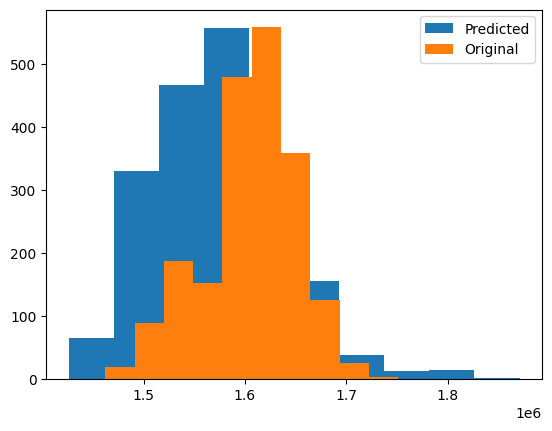

In [17]:
# all_subjects["concave_pred"] = all_subjects["concave"] * all_subjects["vol_ratio"]
plt.hist(all_subjects["concave_pred"], label="Predicted")
plt.hist(all_subjects["concave"], label="Original")
plt.legend()

C:\Users\PieHu\AppData\Local\Temp\ipykernel_11120\2564383087.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df["age"], resvol, label=["CN","MCI","AD"][group], c=colors[group], alpha=0.3, marker=markers[group])
C:\Users\PieHu\AppData\Local\Temp\ipykernel_11120\2564383087.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df["age"].mean(), resvol.mean(), c=colors[group], s=90, marker=markers[group

Text(0.5, 1.0, 'Age and Brain Atrophy by Group')

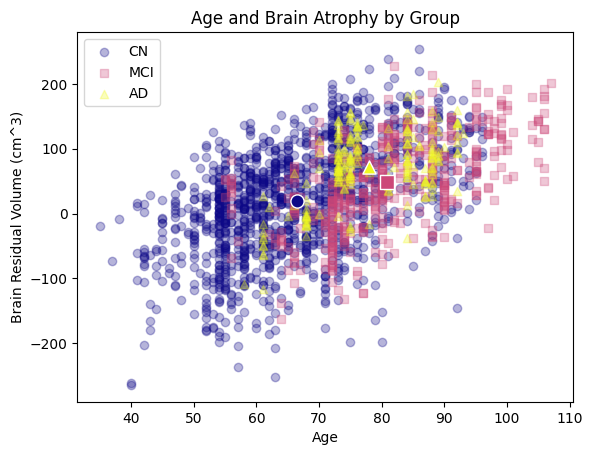

In [18]:
cmap = plt.get_cmap("plasma") # tab10 Set2 Accent plasma
colors = [cmap(i/2) for i in range(3)]
markers = ["o","s","^"]
for group, df in all_subjects.groupby("Group"):
    resvol = (df["concave"] - df["concave_pred"])*1e-3
    plt.scatter(df["age"], resvol, label=["CN","MCI","AD"][group], c=colors[group], alpha=0.3, marker=markers[group])
for group, df in all_subjects.groupby("Group"):
    resvol = (df["concave"] - df["concave_pred"])*1e-3
    plt.scatter(df["age"].mean(), resvol.mean(), c=colors[group], s=90, marker=markers[group], edgecolors="w")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Brain Residual Volume (cm^3)")
plt.title("Age and Brain Atrophy by Group")

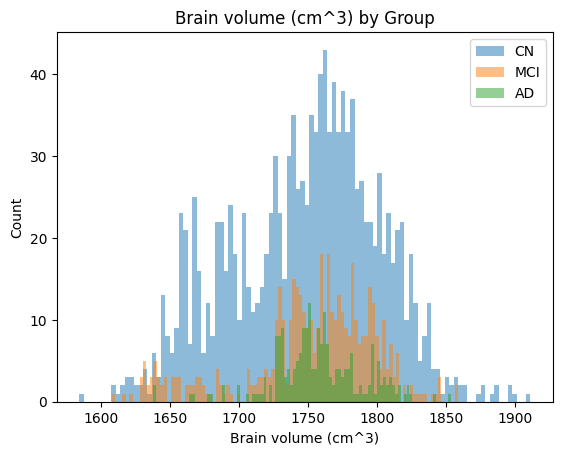

In [20]:
plt.title("Brain volume (cm^3) by Group")
plt.hist(all_subjects[all_subjects["Group"]==0]["convex"]*1e-3, bins=100, label="CN", alpha=0.5)
plt.hist(all_subjects[all_subjects["Group"]==1]["convex"]*1e-3, bins=100, label="MCI", alpha=0.5)
plt.hist(all_subjects[all_subjects["Group"]==2]["convex"]*1e-3, bins=100, label="AD", alpha=0.5)
plt.ylabel("Count")
plt.xlabel("Brain volume (cm^3)")
plt.legend()
plt.show()

In [22]:
c = all_subjects.groupby("Group")["convex"]
means = c.mean()
stds = c.std()
(means - means[0]) / stds[0]

Group
0    0.000000
1    0.065731
2    0.182192
Name: convex, dtype: float64

In [23]:
from scipy.stats import ttest_ind
# Perform t-test between CN and MCI groups
cn_group = all_subjects[all_subjects["Group"] == 0]["convex"]
mci_group = all_subjects[all_subjects["Group"] == 1]["convex"]
t_stat, p_value = ttest_ind(cn_group, mci_group)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.2477852310038, P-value: 0.21227338168835366


In [61]:
all_subjects.groupby("Group")["vol_ratio"].mean()

Group
0    1.005590
1    1.019211
2    1.023282
Name: vol_ratio, dtype: float64

C:\Users\PieHu\AppData\Local\Temp\ipykernel_12356\1787219744.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Effect of Atrophy on MMSE Score')

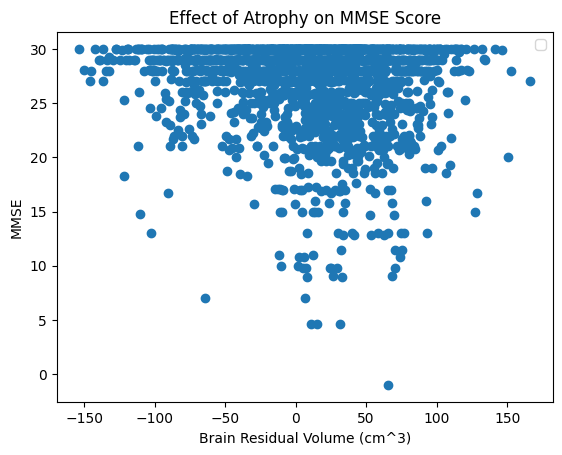

In [100]:
plt.scatter((all_subjects["concave"] - all_subjects["concave_pred"])*1e-3, all_subjects["MMSE_INTERP"])
plt.legend()
plt.xlabel("Brain Residual Volume (cm^3)")
plt.ylabel("MMSE")
plt.title("Effect of Atrophy on MMSE Score")